# 4 Modeling<a id='4_Modeling'></a>

## 4.1 Contents<a id='4.1_Contents'></a>
* [4 Modeling](#3_Modeling)
  * [4.1 Contents](#4.1_Contents)
  * [4.2 Introduction](#4.2_Introduction)
  * [4.3 Imports](#4.3_Imports)
  * [4.4 Load Data](#4.4_Load_Data)
  * [4.5 Reviewing Superficial Modeling](#4.5_Reviewing_Superficial_Modeling)
  * [4.6 XGBoost Classifier](#4.6_XGBoost_Classifier)
      * [4.6.1 Initial Fit](#4.6.1_Initial_Fit)
      * [4.6.2 Oversampling](#4.6.2_Oversampling)
      * [4.6.3 Cross Validation](#4.6.3_Cross_Validation)    
  * [4.7 Bernoulli Naive Bayes](#4.7_Bernoulli_Naive_Bayes)
      * [4.7.1 Initial Fit](#4.7.1_Initial_Fit)
      * [4.7.2 Oversampling](#4.7.2_Oversampling)
      * [4.7.3 Cross Validation](#4.7.3_Cross_Validation)
  * [4.8 Linear Discriminant Analysis](#4.8_Linear_Discriminant_Analysis)
      * [4.8.1 Initial Fit](#4.8.1_Initial_Fit)
      * [4.8.2 Oversampling](#4.8.2_Oversampling)
      * [4.8.3 Cross Validation](#4.8.3_Cross_Validation)
  * [4.9 Optimizing XGBoost](#4.9_Optimizing_XGBoost)
  * [4.10 Test On Unseen Data](#4.10_Test_On_Unseen_Data)
      * [4.10.1 Load Data](#4.10.1_Load_Data)
      * [4.10.2 Data Wrangling](#4.10.2_Data_Wrangling)
      * [4.10.3 Missing Features](#4.10.3_Missing_Features)
      * [4.10.4 Retrain Model](#4.10.4_Retrain_Model)
      * [4.10.5 One-Hot Encoding](#4.10.5_One-Hot_Encoding)
      * [4.10.6 Test Model](#4.10.6_Test_Model)
  * [4.11 Retrain with Unseen Data](#4.11_Retrain_with_Unseen_Data)

## 4.2 Introduction<a id='4.2_Introduction'></a>

The final step of the project will be to figure out which model will make the most accurate and efficient classifications for predicting which loans are likely to default. Then we will optimize the model's predicitive power to maximize its classification capability.

## 4.3 Imports<a id='4.3_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score, learning_curve, validation_curve
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

sns.set()
pd.set_option('display.max_columns',50)

First, we import the appropriate libraries we will need to achieve our goal. We imported the `warnings` library and filter any warnings for cleaner output.

## 4.4 Load Data<a id='4.4_Load_Data'></a>

In [2]:
df_encoded = pd.read_csv('../data/processed/df_encoded.csv', index_col=0)

We load in the encoded dataset generated in the previous step where we pre-processed the data. We will not review with .head() since there are many columns now created from the one-hot encoding.

## 4.5 Reviewing Superficial Modeling<a id='4.5_Reviewing_Superficial_Modeling'></a>

In [3]:
models = pd.read_csv('../data/processed/lazypredict_models.csv')

In the previous notebook, we saved a copy of LazyPredict's summary for different classification models and their results. We import the DataFrame, that had been saved as a csv file, to help us decide which model we will begin with. 

In [4]:
models.sort_values(['F1 Score','Accuracy'], ascending=False)

,Model,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
9,XGBClassifier,0.842045,0.518938,0.518938,0.789942,0.222200
11,BernoulliNB,0.841004,0.518324,0.518324,0.789329,0.063057
13,LinearDiscriminantAnalysis,0.848813,0.512170,0.512170,0.787517,0.137125
12,BaggingClassifier,0.838505,0.514305,0.514305,0.786484,5.020552
10,KNeighborsClassifier,0.829654,0.518714,0.518714,0.786165,0.725659
14,LGBMClassifier,0.849021,0.508047,0.508047,0.784907,0.224205
15,CalibratedClassifierCV,0.849438,0.507726,0.507726,0.784757,0.399363
16,AdaBoostClassifier,0.848605,0.507519,0.507519,0.784500,2.017842
17,ExtraTreesClassifier,0.848605,0.506670,0.506670,0.783941,3.796458
18,LogisticRegression,0.848709,0.505882,0.505882,0.783432,0.075068


We sort the models by F1 score and accuracy. The F1 score will be a crucial component in optimizing our model due to the nature of our problem. A loan default is a case that doesn't occur often; therefore, accuracy alone will provide a misleading account for how well the model performs since there is a class imbalance.

It is evident from the ROC AUC that the models are currently only as good as guessing that all loans are non-defaulted, since they are close to 50%. The top three models that we will take a deeper dive into are: XGBClassifier, BernoulliNB, and LinearDiscriminantAnalysis. We will attempt to optimize the three models and see which one yields the best results.

## 4.6 XGBoost Classifier<a id='4.6_XGBoost_Classifier'></a>

In [5]:
X = df_encoded.drop(columns=['addr_state','earliest_cr_line','repay_fail'])
y = df_encoded.repay_fail

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

We begin with the XGBoost Classifier by splitting the data into training and test datasets. We make sure to stratify the data based on the class we want to predict: `repay_fail`.

### 4.6.1 Initial Fit<a id='4.6.1_Initial_Fit'></a>

In [6]:
# Initialize model
xgb_model = XGBClassifier(random_state=42)

# Fit model to training data
xgb_model.fit(X_train, y_train)

# Predict on test data
xgb_predictions = xgb_model.predict(X_test)

# Get prediction probabilities
xgb_probs = xgb_model.predict_proba(X_test)[:,1]

# Evaluate predictions
display(pd.DataFrame(classification_report(y_test, xgb_predictions,output_dict=True)).T)
print("XGBoost AUC: ", roc_auc_score(y_test, xgb_probs))

,precision,recall,f1-score,support
0,0.853791,0.982090,0.913458,8152.000000
1,0.356828,0.055785,0.096486,1452.000000
accuracy,0.842045,0.842045,0.842045,0.842045
macro avg,0.605310,0.518938,0.504972,9604.000000
weighted avg,0.778657,0.842045,0.789942,9604.000000


XGBoost AUC:  0.6773195477389652


Based on the accuracy of the initial fit, it is evident the model is as good at guessing that all loans are non-defaulted because the amount of defaulted loans is 15%, and the precision of the model for the non-defaulted loans is 85%.

In [7]:
df_encoded.repay_fail.value_counts(normalize=True)

0    0.848835
1    0.151165
Name: repay_fail, dtype: float64

Here we confirm our suspicion by displaying the proportion of defaulted and non-defaulted loans.

### 4.6.2 Oversampling<a id='4.6.2_Oversampling'></a>

The technique we will utilize to counteract the imbalance of classes is oversampling the defaulted loans.

In [8]:
df_encoded.repay_fail.value_counts(normalize=True)

0    0.848835
1    0.151165
Name: repay_fail, dtype: float64

We can see that only 15% of the loans in our dataset are defaults, which explains why our model isn't good at predicting defaults.

In [9]:
# Create two different dataframe of majority and minority class 
df_majority = df_encoded[df_encoded['repay_fail']==0]
df_minority = df_encoded[df_encoded['repay_fail']==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples= 32608,
                                 random_state=42)

# Concatenate the DataFrames with the upsampled minority class and the majority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

We create an upsampled DataFrame to have an equal amount of defaulted and non-defaulted loans.

In [10]:
df_upsampled['repay_fail'].value_counts()

1    32608
0    32608
Name: repay_fail, dtype: int64

Now there are an equal amount of both classes.

In [11]:
X_o = df_upsampled.drop(columns=['addr_state','earliest_cr_line','repay_fail'])
y_o = df_upsampled.repay_fail

The data gets split once again into the features we will use to train the model and the feature we want to predict. A suffix `_o` is added to represent 'oversampled' data.

In [12]:
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_o, y_o, test_size=0.25, random_state=42)

This time over we will not have to stratify since there are an equal amount of both classes.

In [13]:
# Initialize the model
xgb_o = XGBClassifier(random_state=42)

#Fit model to training data
xgb_o.fit(X_train_o, y_train_o)

# Predict on test data
xgb_pred_o = xgb_o.predict(X_test)

# Obtain prediction probabilities
xgb_probs_o = xgb_o.predict_proba(X_test)[:,1]

# Evaluate predictions
display(pd.DataFrame(classification_report(y_test, xgb_pred_o,output_dict=True)).T)
print("XGBoost AUC: ", roc_auc_score(y_test, xgb_probs_o))

,precision,recall,f1-score,support
0,0.972117,0.821148,0.890278,8152.000000
1,0.463576,0.867769,0.604317,1452.000000
accuracy,0.828197,0.828197,0.828197,0.828197
macro avg,0.717847,0.844458,0.747297,9604.000000
weighted avg,0.895233,0.828197,0.847044,9604.000000


XGBoost AUC:  0.921127874786765


The model has improved with the oversampled data; however, it seems it does not have great precision when it comes to predicting the defaulted loans; however, when it does predict that a loan is defaulted, it is correct a lot of the time.

### 4.6.3 Cross Validation<a id='4.6.3_Cross_Validation'></a>

In [14]:
# Create parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
    'min_child_weight': [1, 5],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.5],
}

# Initialize model
xgb_o_2 = XGBClassifier(random_state=42)

# Fit model to training data
xgb_o_2.fit(X_train_o, y_train_o)

# Initialize the grid search
xgb_grid_search = GridSearchCV(estimator=xgb_o_2, 
                           param_grid=param_grid, 
                           scoring='f1', 
                           n_jobs=-1, 
                           cv=3, 
                           verbose=1)

# Fit the grid search to the data
xgb_grid_search.fit(X_train_o, y_train_o)

# Print the best parameters found
print("Best parameters found: ", xgb_grid_search.best_params_)
print("Best F1 found: ", xgb_grid_search.best_score_)

Fitting 3 folds for each of 512 candidates, totalling 1536 fits
Best parameters found:  {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}
Best F1 found:  0.7788276195217919


We have tuned the hyperparamters via cross-validtion while focusing on maximizing the F1 score, which is appropriate for our class-imbalance problem. The F1 aligns closely to the scores we received before; therefore, it's likely the model did not improve with cross-validation.

In [15]:
# Predict on test data
xgb_grid_search_pred = xgb_grid_search.predict(X_test)

# Get prediction probabilities
xgb_grid_search_prob = xgb_grid_search.predict_proba(X_test)[:,1]

# Evaluate predictions
display(pd.DataFrame(classification_report(y_test, xgb_grid_search_pred,output_dict=True)).T)
print("XGBClassifier AUC: ", roc_auc_score(y_test, xgb_grid_search_prob))

,precision,recall,f1-score,support
0,0.964972,0.794161,0.871274,8152.000000
1,0.420380,0.838154,0.559926,1452.000000
accuracy,0.800812,0.800812,0.800812,0.800812
macro avg,0.692676,0.816158,0.715600,9604.000000
weighted avg,0.882637,0.800812,0.824202,9604.000000


XGBClassifier AUC:  0.901691594214065


The model seems to have performed better before cross-validation, although the results are fairly close. The results support XGBClassifier as our best candidate for achieving our goal.

## 4.7 Bernoulli Naive Bayes<a id='4.7_Bernoulli_Naive_Bayes'></a>

### 4.7.1 Initial Fit<a id='4.7.1_Initial_Fit'></a>

In [16]:
# Initialize the model
bnb_model = BernoulliNB()

# Fit the model to training data
bnb_model.fit(X_train, y_train)

# Predict on test data
bnb_pred = bnb_model.predict(X_test)

# Get prediction probabilities
bnb_probs = bnb_model.predict_proba(X_test)[:,1]

# Evaluate predictions
display(pd.DataFrame(classification_report(y_test, bnb_pred,output_dict=True)).T)
print("BernoulliNB AUC: ", roc_auc_score(y_test, bnb_probs))

,precision,recall,f1-score,support
0,0.848813,1.000000,0.918225,8152.000000
1,0.000000,0.000000,0.000000,1452.000000
accuracy,0.848813,0.848813,0.848813,0.848813
macro avg,0.424406,0.500000,0.459112,9604.000000
weighted avg,0.720483,0.848813,0.779401,9604.000000


BernoulliNB AUC:  0.6013184075566982


Next we test the BernoulliNB model. The classification report portrays the model's tendency to guess that all loans are non-defaulted, as before.

### 4.7.2 Oversampling<a id='4.7.2_Oversampling'></a>

In [17]:
# Initialize the model
bnb_model_o = BernoulliNB()

# Fit the model to training data
bnb_model_o.fit(X_train_o, y_train_o)

# Predict on test data
bnb_pred_o = bnb_model_o.predict(X_test)

# Get prediction probabilities
bnb_probs_o = bnb_model_o.predict_proba(X_test)[:,1]

# Evaluate predictions
display(pd.DataFrame(classification_report(y_test, bnb_pred_o,output_dict=True)).T)
print("BernoulliNB AUC: ", roc_auc_score(y_test, bnb_probs_o))

,precision,recall,f1-score,support
0,0.884697,0.563788,0.688694,8152.000000
1,0.193468,0.587466,0.291077,1452.000000
accuracy,0.567368,0.567368,0.567368,0.567368
macro avg,0.539082,0.575627,0.489885,9604.000000
weighted avg,0.780192,0.567368,0.628579,9604.000000


BernoulliNB AUC:  0.604187533962157


After using the oversampled data, the results are better; however, the XGBClassifier is still better at predicting.

### 4.7.3 Cross Validation<a id='4.7.3_Cross_Validation'></a>

In [18]:
# Create parameter grid
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0],
    'binarize': [0.0, 0.1, 0.2, 0.5]
}

# Initialize the model
bnb_o_2 = BernoulliNB()

# Fit model to training data
bnb_o_2.fit(X_train_o, y_train_o)

# Initialize the grid search
bnb_grid_search = GridSearchCV(estimator=bnb_o_2, 
                           param_grid=param_grid, 
                           scoring='f1', 
                           n_jobs=-1, 
                           cv=3, 
                           verbose=1)

# Fit the grid search to the data
bnb_grid_search.fit(X_train_o, y_train_o)

# Print the best parameters found
print("Best parameters found: ", bnb_grid_search.best_params_)
print("Best F1 found: ", bnb_grid_search.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters found:  {'alpha': 0.01, 'binarize': 0.2}
Best F1 found:  0.5694216317671819


Here we completed the cross-validation via GridSearch for the BernoulliNB. The F1 score seems to show that the model performs slightly worse after completing the hyperparameter tuning.

In [19]:
# Predict on test data
bnb_grid_search_pred = bnb_grid_search.predict(X_test)

# Get prediction probabilities
bnb_grid_search_prob = bnb_grid_search.predict_proba(X_test)[:,1]

# Evaluate predictions
display(pd.DataFrame(classification_report(y_test, bnb_grid_search_pred,output_dict=True)).T)
print("BernoulliNB AUC: ", roc_auc_score(y_test, bnb_grid_search_prob))

,precision,recall,f1-score,support
0,0.884512,0.564647,0.689278,8152.000000
1,0.193409,0.586088,0.290841,1452.000000
accuracy,0.567888,0.567888,0.567888,0.567888
macro avg,0.538961,0.575367,0.490059,9604.000000
weighted avg,0.780026,0.567888,0.629040,9604.000000


BernoulliNB AUC:  0.6039284246695702


The model performance did not improve after the cross-validation. Our best candidate is still the XGBClassifier. 

## 4.8 Linear Discriminant Analysis<a id='4.8_Linear_Discriminant_Analysis'></a>

### 4.8.1 Initial Fit<a id='4.8.1_Initial_Fit'></a>

In [20]:
# Initialize the model
lda_model = LinearDiscriminantAnalysis()

# Fit model to the training data
lda_model.fit(X_train, y_train)

# Predict on test data
lda_pred = lda_model.predict(X_test)

# Get prediction probabilities
lda_probs = lda_model.predict_proba(X_test)[:,1]

# Evaluate predictions
display(pd.DataFrame(classification_report(y_test, lda_pred,output_dict=True)).T)
print("LinearDiscriminantAnalysis AUC: ", roc_auc_score(y_test, lda_probs))

,precision,recall,f1-score,support
0,0.851965,0.994725,0.917827,8152.000000
1,0.500000,0.029614,0.055917,1452.000000
accuracy,0.848813,0.848813,0.848813,0.848813
macro avg,0.675982,0.512170,0.486872,9604.000000
weighted avg,0.798752,0.848813,0.787517,9604.000000


LinearDiscriminantAnalysis AUC:  0.7091479182042568


Next we test the LinearDiscriminantAnalysis model. The classification report, once again, displays the model's tendency to guess that all loans are non-defaulted.

### 4.8.2 Oversampling<a id='4.8.2_Oversampling'></a>

In [21]:
lda_o = LinearDiscriminantAnalysis()

lda_o.fit(X_train_o, y_train_o)

# Predict on test data
lda_pred_o = lda_o.predict(X_test)

# Get prediction probabilities
lda_probs_o = lda_o.predict_proba(X_test)[:,1]

# Evaluate predictions
display(pd.DataFrame(classification_report(y_test, lda_pred_o,output_dict=True)).T)
print("LinearDiscriminantAnalysis AUC: ", roc_auc_score(y_test, lda_probs_o))

,precision,recall,f1-score,support
0,0.911366,0.652110,0.760243,8152.000000
1,0.247945,0.643939,0.358032,1452.000000
accuracy,0.650875,0.650875,0.650875,0.650875
macro avg,0.579656,0.648025,0.559137,9604.000000
weighted avg,0.811066,0.650875,0.699434,9604.000000


LinearDiscriminantAnalysis AUC:  0.7103123470858104


The model had slightly has improved when utilizing the oversampled data; however, it is performing more closely to the BernoulliNB. 

### 4.8.3 Cross Validation<a id='4.8.3_Cross_Validation'></a>

In [22]:
# Create parameter grid
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto', 0.0, 0.5, 1.0],
    'tol': [0.0001, 0.0002, 0.0005]
}

# Initialize model
lda_o_2 = LinearDiscriminantAnalysis()

# Fit model to the training data
lda_o_2.fit(X_train_o, y_train_o)

# Initialize the grid search
lda_grid_search = GridSearchCV(estimator=lda_o_2, 
                           param_grid=param_grid, 
                           scoring='f1', 
                           n_jobs=-1, 
                           cv=3, 
                           verbose=1)

# Fit the grid search to the data
lda_grid_search.fit(X_train_o, y_train_o)

# Print the best parameters found
print("Best parameters found: ", lda_grid_search.best_params_)
print("Best F1 found: ", lda_grid_search.best_score_)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Best parameters found:  {'shrinkage': 'auto', 'solver': 'lsqr', 'tol': 0.0001}
Best F1 found:  0.6440942491872834


The F1 score suggest that the model didn't improve from cross-validation.

In [23]:
lda_best_model = lda_grid_search.best_estimator_
lda_predictions_cv = lda_best_model.predict(X_test)
lda_probs_cv = lda_best_model.predict_proba(X_test)[:,1]

display(pd.DataFrame(classification_report(y_test, lda_predictions_cv,output_dict=True)).T)
print("LinearDiscriminantAnalysis AUC: ", roc_auc_score(y_test, lda_probs_cv))

,precision,recall,f1-score,support
0,0.912082,0.652846,0.760992,8152.000000
1,0.249138,0.646694,0.359701,1452.000000
accuracy,0.651916,0.651916,0.651916,0.651916
macro avg,0.580610,0.649770,0.560347,9604.000000
weighted avg,0.811854,0.651916,0.700322,9604.000000


LinearDiscriminantAnalysis AUC:  0.7102626710949265


Our suspicion has been confirmed, the model did not improve after hyperparameter tuning. We will continue in optimizing XGBoost Classifier to create a model for predicting loan default.

## 4.9 Optimizing XGBoost<a id='4.9_Optimizing_XGBoost'></a>

To optimize XGBClassifier, we will find out which hyperparameters create the greatest change in the model's F1 score. That way, we can leave the hyperparameters that don't greatly affect the model's ability to predict as the hyperparameter values that we found previously, and run a cross-validation grid search with only the hyperparameters that do greatly affect the model's ability to predict.

In [24]:
# Create parameter grid with potential values for various hyperparameters
potential_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.05, 0.1, 0.2, 0.3],
    'reg_lambda': [0.8, 1.0, 1.2, 1.5, 1.7],
    }

# Initialize empty parameter dictionary
param_dict = {}

# Iterate through potential parameter grid
for param, values in potential_grid.items():
    
    # Initialize optimal parameters dictionary
    # The current values are the optimal values found after CV of XGBoost
    optimal_params = {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 
                  'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}
    
    # Add parameter as a key to param_dict if not already created
    if param not in param_dict:
        param_dict[param] = {}
    
    # Iterate through the list of values for each hyperparamter
    for value in values:
        
        # Change value for hyperparameter in optimal_params while keeping all others the same
        optimal_params[param] = value
        
        # Initialize temporary model
        xgb_temp = XGBClassifier(**optimal_params, random_state=42)

        # Fit temporary model to the training data
        xgb_temp.fit(X_train_o, y_train_o)

        # Predict on test data
        xgb_pred_temp = xgb_temp.predict(X_test)

        # Save F1 score to the param_dict
        param_dict[param][value] = f1_score(y_test, xgb_pred_temp)

We create a dictionary that stores the f1 score of the model while changing one of the hyperparameter's values and keeping all the other ones the same.

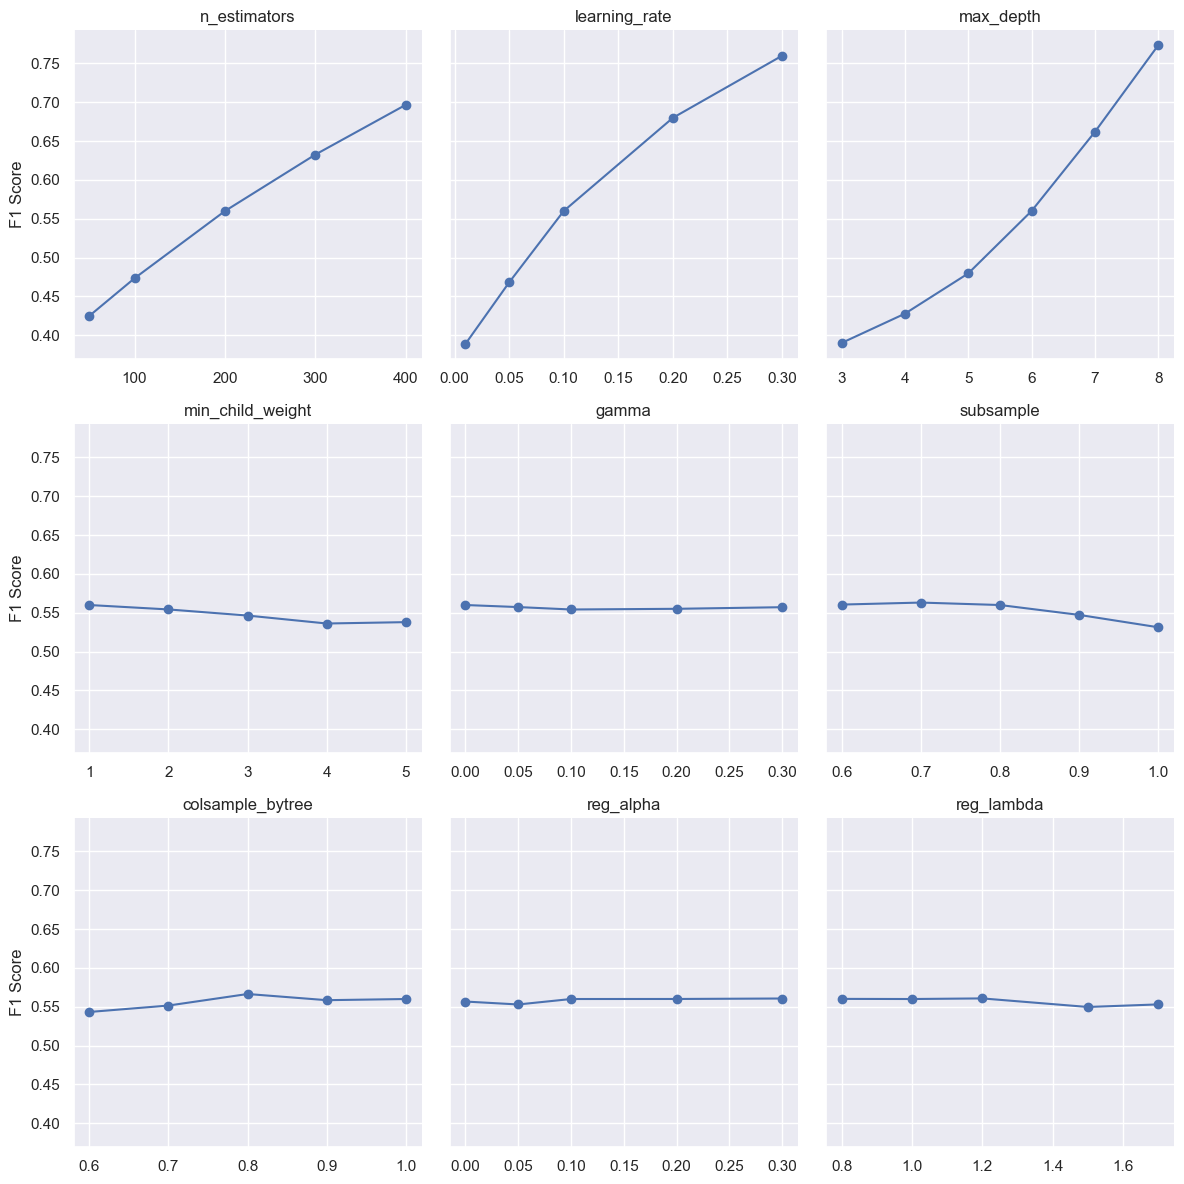

In [25]:
# Initialize empty list
data = []

# Iterate through param_dict dictionary
for param, values in param_dict.items():
    
    # Iterate through list for each hyperparameter
    for value, score in values.items():
        
        # Append a dictionary that stores the paramter name, value and F1 score
        data.append({'Parameter': param, 'Value': value, 'F1 Score': score})
        
# Convert the list into a DataFrame
df = pd.DataFrame(data)

# Create a FacetGrid plotting separating each column by parameter 
g = sns.FacetGrid(df, col="Parameter", col_wrap=3, height=4, sharey=True, sharex=False)
g.map(plt.plot, "Value", "F1 Score", marker="o")

# Add labels and titles
g.set_axis_labels("", "F1 Score")
g.set_titles("{col_name}")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

It is evident here which hyperparamters greatly affect the F1 score the most.

Significant hyperparameters:
 - learning_rate
 - max_depth
 - n_estimators
 
Insiginificant hyperparameters:
 - gamma
 - colsample_bytree
 - min_child_weight
 - subsample
 - reg_lambda
 - reg_alpha

In [26]:
# Create parameter grid
new_param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8],
}

# Initialize optimal parameters dictionary with values found previously
optimal_params = {'colsample_bytree': 1.0, 'gamma': 0.1, 'min_child_weight': 1, 'reg_alpha': 0.1,
                  'reg_lambda': 1, 'subsample': 0.8}

# Initialize model
xgb_o_3 = XGBClassifier(**optimal_params, random_state=42)

# Fit model to the training data
xgb_o_3.fit(X_train_o, y_train_o)

# Initialize the grid search
xgb_grid_search_2 = GridSearchCV(estimator=xgb_o_3, 
                           param_grid=new_param_grid, 
                           scoring='f1', 
                           n_jobs=-1, 
                           cv=3, 
                           verbose=1)

# Fit the grid search to the data
xgb_grid_search_2.fit(X_train_o, y_train_o)

# Print the best parameters found
print("Best parameters found: ", xgb_grid_search_2.best_params_)
print("Best F1 found: ", xgb_grid_search_2.best_score_)

Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best parameters found:  {'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 400}
Best F1 found:  0.9127963682131309


Leaving the insignificant hyperparameters at the optimized values found when first using grid search cross-validation, we use another grid search with a larger range of values for the significant hyperparameters. It is evident from the F1 that the model has improved since the score has increased to over 91%.

In [27]:
y_pred_2 = xgb_grid_search_2.predict(X_test)
y_probs_2 = xgb_grid_search_2.predict_proba(X_test)[:,1]

display(pd.DataFrame(classification_report(y_test, y_pred_2,output_dict=True)).T)
print("XGBoost AUC: ", roc_auc_score(y_test, y_probs_2))

,precision,recall,f1-score,support
0,0.998495,0.976938,0.987599,8152.000000
1,0.884521,0.991736,0.935065,1452.000000
accuracy,0.979175,0.979175,0.979175,0.979175
macro avg,0.941508,0.984337,0.961332,9604.000000
weighted avg,0.981264,0.979175,0.979657,9604.000000


XGBoost AUC:  0.9962265678013068


The scores are seriously high now, almost at 100%. This suggests that the model has overfit to the training data.

## 4.10 Test On Unseen Data<a id='4.10_Test_On_Unseen_Data'></a>

What we will do since the model has likely overfit to the data is test the model on unseen data. 

### 4.10.1 Load Data<a id='4.10.1_Load_Data'></a>

In [28]:
loan_test_data = pd.read_csv('../data/raw/loan_default_test_data.csv')

We have gathered a new dataset with similar features.

In [29]:
loan_test_data.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


Here is an overview of the new dataset's features.

In [30]:
loan_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

Here we run the .info() method on the new dataset. We can see that the new dataset is much larger with over 250,000 rows of data. We will need to convert the features to match our dataset's before we can make predictions with our model.

### 4.10.2 Data Wrangling<a id='4.10.2_Data_Wrangling'></a>

In [31]:
missing = pd.concat([loan_test_data.isnull().sum(), 100 * loan_test_data.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by=['count'], ascending = False)

,count,%
LoanID,0,0.0
Age,0,0.0
HasCoSigner,0,0.0
LoanPurpose,0,0.0
HasDependents,0,0.0
HasMortgage,0,0.0
MaritalStatus,0,0.0
EmploymentType,0,0.0
Education,0,0.0
DTIRatio,0,0.0


First, we take a look to see if the dataset contains any missing values. Fortunately, there is no missing data.

In [32]:
u_data_filtered = loan_test_data.loc[:,['LoanPurpose','HasMortgage','DTIRatio',
                                           'LoanTerm','InterestRate','NumCreditLines','MonthsEmployed',
                                          'LoanAmount','Income','Default']]

The features that closely match with our dataset are shown in the cell above as those are the only ones we keep from the unseen dataset. Note that the prefix `u_` was used to represent 'unseen' data.

In [33]:
column_names = {'LoanPurpose':'purpose',
               'HasMortgage':'home_ownership',
               'DTIRatio':'dti',
               'LoanTerm':'term',
               'InterestRate':'int_rate',
               'NumCreditLines':'open_acc',
               'MonthsEmployed':'emp_length',
               'LoanAmount':'loan_amnt',
               'Income':'annual_inc',
               'Default':'repay_fail'}

u_data_filtered.rename(columns=column_names,inplace=True)

We change the names to match the names of the features in the original dataset.

In [34]:
u_data_filtered.purpose.value_counts()

Business     51298
Home         51286
Education    51005
Other        50914
Auto         50844
Name: purpose, dtype: int64

We first check the `purpose` feature and the unique values present.

In [35]:
new_labels = {'Business':'small_business',
             'Home':'home_improvement',
             'Education':'educational',
             'Other':'other',
             'Auto':'car'}

u_data_filtered.purpose.replace(new_labels,inplace=True)

The labels are converted to match the labels in the original dataset.

In [36]:
u_data_filtered.home_ownership.value_counts()

Yes    127677
No     127670
Name: home_ownership, dtype: int64

Next, we take a look at the `home_ownership` unique values.

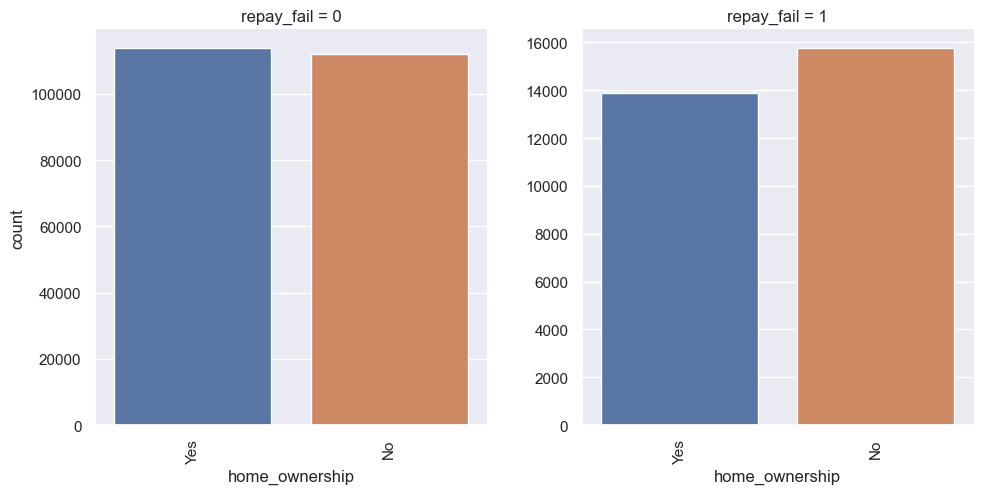

In [37]:
order = u_data_filtered['home_ownership'].value_counts().index
ax = sns.catplot(x = 'home_ownership', kind='count', col = 'repay_fail', data=u_data_filtered, sharey=False,
                order = order)
ax.set_xticklabels(rotation=90)
plt.show()

There are only two unique values in the unseen dataset's `home_ownership` column and the original dataset has three: `MORTGAGE`, `RENT`, and `OWN`. In the unseen dataset, there is `Yes` and `No`. When exploring the original dataset, we found that there were more defaults in homes that were under `RENT` ownership status. That pattern is also followed in the unseen dataset; therefore, it is appropriate to change `Yes` to `MORTGAGE`, and `No` to `RENT` since they follow the same pattern and disregard the `OWN` label given it was a lower proportion of the data.

In [38]:
new_labels = {'Yes':'MORTGAGE',
             'No':'RENT'}

u_data_filtered.loc[:,'home_ownership'].replace(new_labels, inplace=True)

Here we replace the labels and update the dataset.

In [39]:
u_data_filtered.loc[:,'dti'] = u_data_filtered.loc[:,'dti'] * 100

From inspection of the summary of the unseen dataset, the DTI ratios are in decimal format. To convert them to percentage format we multiply by 100.

In [40]:
u_data_filtered.loc[:,'open_acc'] = u_data_filtered.loc[:,'open_acc'].astype('float')

The `open_acc` column is currently integer type; therefore we convert it to float type.

In [41]:
u_data_filtered.loc[:,'emp_length'] = u_data_filtered.loc[:,'emp_length'] / 12
u_data_filtered['emp_length'] = u_data_filtered['emp_length'].apply(np.floor)

u_data_filtered['emp_length'] = u_data_filtered['emp_length'].astype(int)

The `emp_length` column are in terms of months; therefore, we convert them to years by dividing by 12 and rounding them to a whole number. Then, we convert the column to integer type. 

In [42]:
u_data_filtered.loc[:,'loan_amnt'] = u_data_filtered.loc[:,'loan_amnt'].astype('float')

The `loan_amnt` column is correctly converted to a float type.

In [43]:
u_data_filtered.loc[:,'annual_inc'] = u_data_filtered.loc[:,'annual_inc'].astype('float')

The `annual_inc` column is correctly converted to a float type.

### 4.10.3 Missing Features<a id='4.10.3_Missing_Features'></a>

Let's import the data after exploratory data analysis to review which features are missing still.

In [44]:
explored_data = pd.read_csv('../data/interim/explored_data.csv', index_col=0)

First we import explored_data as a DataFrame.

In [45]:
explored_data.columns[~explored_data.columns.isin(u_data_filtered.columns)]

Index(['installment', 'verification_status', 'addr_state', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'annual_inc_log', 'revol_bal_log',
       'years_of_credit'],
      dtype='object')

Here we can see which features are in the `explored_data` DataFrame and not in our unseen data. We will go down the list to impute the values for the missing features.

In [46]:
installment_df = explored_data.loc[:,['installment','loan_amnt','term','int_rate']]

installment_df

,installment,loan_amnt,term,int_rate
3,85.42,2500.0,36,13.98
4,175.67,5000.0,36,15.95
5,225.58,7000.0,36,9.91
6,60.32,2000.0,36,5.42
7,116.59,3600.0,36,10.25
...,...,...,...,...
38476,99.63,3000.0,36,11.99
38477,352.88,10400.0,36,13.49
38478,250.77,16000.0,60,14.96
38479,355.99,10000.0,36,16.89


We create an `installment_df` DataFrame to inspect the variables needed to calculate the installment of the loan. The forumula to calculate the installment is:

$$ \Large A = P\frac{i(1+i)^n}{(1+i)^n-1} $$

Where `A` is the installment, `i` is the interest rate divided by the number of compounding periods (in our case 12 for a year),  and `n` is the term (in months for our scenario). Given the formula and the variables, we can figure out if the installments follow this formula by verifying with the known installments and variables in the original data.

In [47]:
# Define variables
P = installment_df.loan_amnt
i = (installment_df.int_rate/100)/12
n = installment_df.term

var = (1+i)**n

# Create a column that calculates the installment with the amortization formula
installment_df['installment_calc'] = P*(i*var)/(var-1)

In [48]:
installment_df[['installment','installment_calc']]

,installment,installment_calc
3,85.42,85.419792
4,175.67,175.661765
5,225.58,225.574645
6,60.32,60.319663
7,116.59,116.584877
...,...,...
38476,99.63,99.628601
38477,352.88,352.876688
38478,250.77,380.303020
38479,355.99,355.980063


As we can see, the installments are almost exactly the same, meaning they do follow the formula above. Therefore, we will impute the missing values for `installment` with the formula.

In [49]:
P = u_data_filtered.loan_amnt
i = (u_data_filtered.int_rate/100)/12
n = u_data_filtered.term

var = (1+i)**n

u_data_filtered['installment'] = P*(i*var)/(var-1)

The `installment` feature has successfully been created for the unseen data.

In [50]:
u_data_filtered['verification_status'] = explored_data.verification_status.mode()[0]

We impute the missing values for verification_status with the mode, since the majority of the loans in the original data are verified.

In [51]:
u_data_filtered['delinq_2yrs'] = explored_data.delinq_2yrs.mode()[0]

We impute the missing values for `delinq_2yrs` with the mode, since an overwhelming majority of the delinquencies in the original data are 0.

In [52]:
u_data_filtered['inq_last_6mths'] = explored_data.inq_last_6mths.mode()[0]

We impute the missing values for `inq_last_6mths` with the mode, since the majority of the inquiries in the original data are 0.

In [53]:
u_data_filtered['pub_rec'] = explored_data.pub_rec.mode()[0]

We impute the missing values for `pub_rec` with the mode, since an overwhelming majority of the public records in the original data are 0.

In [54]:
u_data_filtered['total_acc'] = u_data_filtered.open_acc

Since there is no way to know what the number closed of accounts are for a client in the unseen data, we will set the total number of accounts equal to the number of open accounts they have.

In [55]:
u_data_filtered['years_of_credit'] = explored_data.years_of_credit.mode()[0]

Since we do not have any data in regard to how long clients have had credit in the unseen data, we will set the number of years in the unseen data to 0 since in the original data a majority of clients have 0 years of credit.

In [56]:
u_data_filtered.loc[:,'annual_inc_log'] = np.log(u_data_filtered['annual_inc'])

To get `annual_inc_log` we simply transform the annual income feature of the unseen data by taking the log of the annual income. 

The missing features still unaccounted for are `revol_bal`, `revol_bal_log` and `revol_util`. These features are the balance of credit card debt and the percentage of their credit limit utilized. With the information we have now, there is no way to calculate the missing data for the revolving debt. Moreover, we cannot simply impute with a mode because the revolving debt varies per customer. There is also `verification_status`, which has about an equal amount of all three statuses. We would not be able to guess what the verification status for each loan is. Therefore, we will take a different approach.

### 4.10.4 Retrain Model<a id='4.10.4_Retrain_Model'></a>

To be able to test on the unseen data and really understand the power of our model, rather than imputing the missing features of the unseen data for the revolving debt, we can retrain a new model that does not include the three missing features and compare how much predictive power the model loses from the missing features. If the model doesn't lose lots of predicitive power, then it is safe that we don't need the features to make predictions.

In [57]:
filtered_data = explored_data.drop(columns=['revol_bal', 'revol_bal_log', 'revol_util', 'addr_state', 'earliest_cr_line'])

First, we take the `explored_data` DataFrame and filter out the features we will not need.

In [58]:
filtered_data.purpose.value_counts()

debt_consolidation    17901
credit_card            4970
other                  3936
home_improvement       3280
major_purchase         2071
small_business         1807
car                    1477
wedding                 908
medical                 673
moving                  559
educational             383
vacation                359
renewable_energy         91
Name: purpose, dtype: int64

Before re-training the model, we could also simplify the `purpose` feature to have a less sparse dataset. We simplify by only keeping the labels that exist in both datasets.

In [59]:
new_labels = {'moving':'other',
             'vacation':'other',
             'renewable_energy':'other',
             'major_purchase':'other',
             'medical':'other',
             'wedding':'other'}

filtered_data.purpose.replace(new_labels, inplace=True)

Now the labels are more simplified.

In [60]:
filtered_data.purpose.value_counts()

debt_consolidation    17901
other                  8597
credit_card            4970
home_improvement       3280
small_business         1807
car                    1477
educational             383
Name: purpose, dtype: int64

Here is a snapshot of the new categories.

In [61]:
df_encoded_2 = pd.get_dummies(filtered_data, drop_first=True)

We encode the new filtered dataset.

In [62]:
# Create two different dataframe of majority and minority class 
df_majority = df_encoded_2[(df_encoded_2['repay_fail']==0)]
df_minority = df_encoded_2[(df_encoded_2['repay_fail']==1)]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples= 32608,
                                 random_state=42)

# Concatenate the DataFrames with the upsampled minority class and the majority class
df_upsampled_2 = pd.concat([df_minority_upsampled, df_majority])

We oversample the new encoded dataset to train the data with.

In [63]:
X_filt = df_upsampled_2.drop(columns=['repay_fail'])
y_filt = df_upsampled_2.repay_fail

X_train_filt, X_test_filt, y_train_filt, y_test_filt = train_test_split(X_filt, y_filt, test_size=0.25, random_state=42)

The data is then split.

In [64]:
# Initialize model
xgb_filt = XGBClassifier(random_state=42)

# Fit model to training data
xgb_filt.fit(X_train_filt, y_train_filt)

# Remove columns in the original test data
X_test_retrain = X_test.drop(columns=['purpose_renewable_energy', 'purpose_vacation', 'purpose_moving', 
                                      'revol_bal', 'revol_util', 'purpose_wedding', 'revol_bal_log', 
                                      'purpose_medical', 'purpose_major_purchase'])

# Predict on test data
y_pred_filt = xgb_filt.predict(X_test_retrain)

# Get prediction probabilities
y_probs_filt = xgb_filt.predict_proba(X_test_retrain)[:,1]

# Evaluate predictions
display(pd.DataFrame(classification_report(y_test, y_pred_filt,output_dict=True)).T)
print("XGBoost AUC: ", roc_auc_score(y_test, y_probs_filt))

,precision,recall,f1-score,support
0,0.964286,0.804833,0.877374,8152.000000
1,0.431786,0.832645,0.568674,1452.000000
accuracy,0.809038,0.809038,0.809038,0.809038
macro avg,0.698036,0.818739,0.723024,9604.000000
weighted avg,0.883779,0.809038,0.830702,9604.000000


XGBoost AUC:  0.9049068051376464


When retraining the model, we drop the columns that no longer exist in the training data to make predicitions on our original test set. We name the subset of the `X_test` DataFrame `X_test_retrain` to represent the retraining of the model. The results are very close to what we obtained originally; therefore, it is safe to assume we didn't lose much predicitive power in the model when removing the features that could not be imputed.

In [65]:
# Create parameter grid with potential values for various hyperparameters
potential_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.05, 0.1, 0.2, 0.3],
    'reg_lambda': [0.8, 1.0, 1.2, 1.5, 1.7],
    }

# Initialize empty parameter dictionary
param_dict = {}

# Iterate through potential parameter grid
for param, values in potential_grid.items():
    
    # Initialize optimal parameters dictionary
    # The current values are the optimal values found after CV of XGBoost
    optimal_params = {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 
                  'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}
    
    # Add parameter as a key to param_dict if not already created
    if param not in param_dict:
        param_dict[param] = {}
    
    # Iterate through the list of values for each hyperparamter
    for value in values:
        
        # Change value for hyperparameter in optimal_params while keeping all others the same
        optimal_params[param] = value
        
        # Initialize temporary model
        xgb_temp = XGBClassifier(**optimal_params, random_state=42)

        # Fit temporary model to the training data
        xgb_temp.fit(X_train_filt, y_train_filt)
        
        # Predict on test data
        xgb_pred = xgb_temp.predict(X_test_filt)

        # Save F1 score to the param_dict
        param_dict[param][value] = f1_score(y_test_filt, xgb_pred)

To optimize the model's predictive power, we follow the same method as before to find which hyperparameters make the biggest difference.

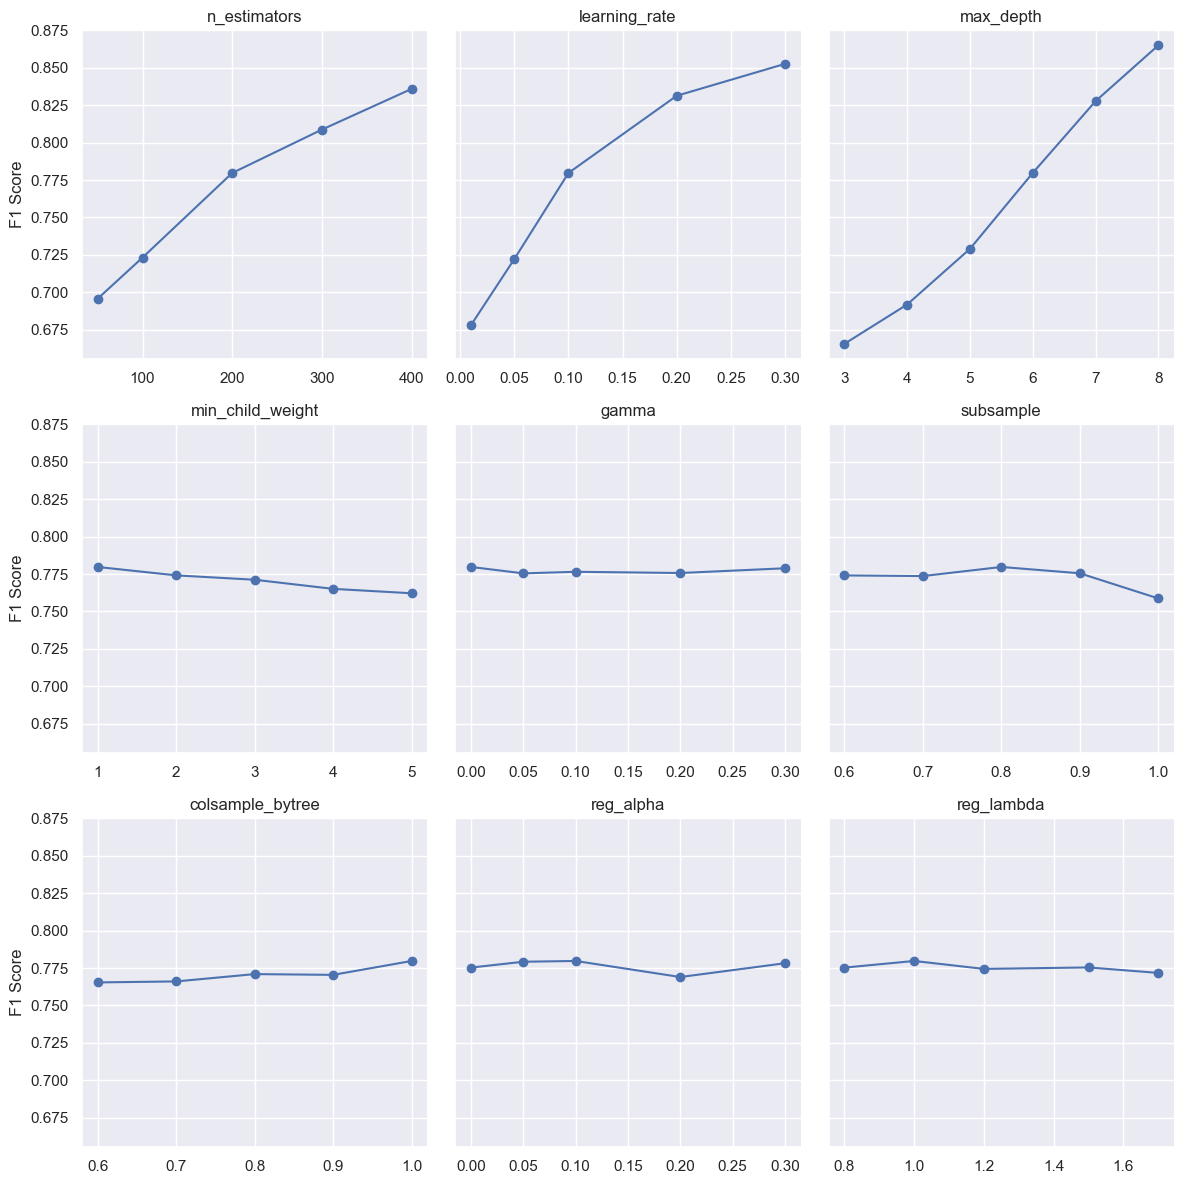

In [66]:
# Initialize empty list
data = []

# Iterate through param_dict dictionary
for param, values in param_dict.items():
    
    # Iterate through list for each hyperparameter
    for value, score in values.items():
        
        # Append a dictionary that stores the paramter name, value and F1 score
        data.append({'Parameter': param, 'Value': value, 'F1 Score': score})
        
# Convert the list into a DataFrame
df = pd.DataFrame(data)

# Create a FacetGrid plotting separating each column by parameter 
g = sns.FacetGrid(df, col="Parameter", col_wrap=3, height=4, sharey=True, sharex=False)
g.map(plt.plot, "Value", "F1 Score", marker="o")

# Adding labels and titles
g.set_axis_labels("", "F1 Score")
g.set_titles("{col_name}")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

The plots show once again that `n_estimators`, `learning_rate` and `max_depth` are the most significant hyperparameters in making a difference. 

In [67]:
# Create parameter grid
param_grid = {
    'min_child_weight': [1, 5],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.5]
}

# Initialize temporary model
xgb_temp = XGBClassifier(random_state=42)

# Fit temporary model to training data
xgb_temp.fit(X_train_filt, y_train_filt)

# Initialize the grid search
xgb_grid_search_filt = GridSearchCV(estimator=xgb_temp, 
                           param_grid=param_grid, 
                           scoring='f1', 
                           n_jobs=-1, 
                           cv=3, 
                           verbose=1)

# Fit the grid search to the data
xgb_grid_search_filt.fit(X_train_filt, y_train_filt)

# Print the best parameters found
print("Best parameters found: ", xgb_grid_search_filt.best_params_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best parameters found:  {'colsample_bytree': 1.0, 'gamma': 0.1, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 1.5, 'subsample': 0.8}


We find the optimal hyperparameters without the three most significant hyperparameters.

In [68]:
# Create parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8],
}

# Initialize optimal parameters dictionary with values found previously
optimal_params = {'colsample_bytree': 1.0, 'gamma': 0.1, 'min_child_weight': 1, 
                  'reg_alpha': 0, 'reg_lambda': 1.5, 'subsample': 0.8}

# Initialize temporary model
xgb_temp = XGBClassifier(**optimal_params, random_state=42)

# Fit temporary model to training data
xgb_temp.fit(X_train_filt, y_train_filt)

# Initialize the grid search
xgb_grid_search_filt = GridSearchCV(estimator=xgb_temp, 
                           param_grid=param_grid, 
                           scoring='f1', 
                           n_jobs=-1, 
                           cv=3, 
                           verbose=1)

# Fit the grid search to the data
xgb_grid_search_filt.fit(X_train_filt, y_train_filt)

# Print the best parameters found
print("Best parameters found: ", xgb_grid_search_filt.best_params_)
print("Best F1 found: ", xgb_grid_search_filt.best_score_)

Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best parameters found:  {'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 400}
Best F1 found:  0.9075204927849728


The best F1 score found suggests possible overfitting of the model since it is over 90%.

In [69]:
# Predict on test data
y_pred_gs_filt = xgb_grid_search_filt.predict(X_test_retrain)

# Get prediction probabilities
y_probs_gs_filt = xgb_grid_search_filt.predict_proba(X_test_retrain)[:,1]

# Evaluate predictions
display(pd.DataFrame(classification_report(y_test, y_pred_gs_filt,output_dict=True)).T)
print("XGBoost AUC: ", roc_auc_score(y_test, y_probs_gs_filt))

,precision,recall,f1-score,support
0,0.998492,0.974730,0.986468,8152.000000
1,0.874848,0.991736,0.929632,1452.000000
accuracy,0.977301,0.977301,0.977301,0.977301
macro avg,0.936670,0.983233,0.958050,9604.000000
weighted avg,0.979799,0.977301,0.977875,9604.000000


XGBoost AUC:  0.994733077721636


Our suspicion is confirmed when testing on the original test data that the model is likely overfit. The predictive power of the model did not go down much from the removal of the features. 

### 4.10.5 One-Hot Encoding<a id='4.10.5_One-Hot_Encoding'></a>

In [70]:
u_data_encoded = pd.get_dummies(u_data_filtered, drop_first=True)

We prepare the unseen data for testing by one-hot encoding.

In [71]:
u_data_encoded.loc[:, 'home_ownership_OWN'] = 0
u_data_encoded.loc[:, 'home_ownership_OTHER'] = 0
u_data_encoded.loc[:, 'purpose_debt_consolidation'] = 0
u_data_encoded.loc[:, 'purpose_credit_card'] = 0
u_data_encoded.loc[:, 'verification_status_Verified'] = 0

Since we imputed by the mode, we manually add the encoded columns that are in the training data that do not appear in the unseen data.

### 4.10.6 Test Model<a id='4.10.6_Test_Model'></a>

In [72]:
X_u_data = u_data_encoded.drop(columns='repay_fail')
y_u_data = u_data_encoded.repay_fail

# Reordering columns of X_u_data to match the training data's feature order
X_u_data = X_u_data[['loan_amnt', 'term', 'int_rate', 'installment', 
                     'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 
                     'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc', 
                     'annual_inc_log', 'years_of_credit', 'home_ownership_OTHER', 
                     'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Verified',
                     'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 
                     'purpose_home_improvement', 'purpose_other', 'purpose_small_business']]

To successfully test on the unseen data, we must reorder the unseen data to match the order of the training data.

In [73]:
# Predict on test data
y_pred_u_data = xgb_grid_search_filt.predict(X_u_data)

# Get prediction probabilities
y_probs_u_data = xgb_grid_search_filt.predict_proba(X_u_data)[:,1]

# Evaluate predictions
display(pd.DataFrame(classification_report(y_u_data, y_pred_u_data,output_dict=True)).T)
print("XGBoost AUC: ", roc_auc_score(y_u_data, y_probs_u_data))

,precision,recall,f1-score,support
0,0.884522,0.952475,0.917242,225694.000000
1,0.128959,0.053553,0.075679,29653.000000
accuracy,0.848085,0.848085,0.848085,0.848085
macro avg,0.506740,0.503014,0.496460,255347.000000
weighted avg,0.796780,0.848085,0.819513,255347.000000


XGBoost AUC:  0.5203389717508285


The result is that the model is simply most loans are non-defaulted. This is likely due to the model being overfit to our data. 

## 4.11 Retrain with Unseen Data<a id='4.11_Retrain_with_Unseen_Data'></a>

To combat the overfitting of the model to our original data, we will retrain the model by adding some of the unseen data into the training. That way we will have more generalized data in the training, giving our model more predictive power when it comes to unseen data.

In [74]:
# Create two different dataframe of majority and minority class 
df_majority = u_data_encoded[(u_data_encoded['repay_fail']==0)]
df_minority = u_data_encoded[(u_data_encoded['repay_fail']==1)]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,
                                 n_samples= len(df_minority),
                                 random_state=42)

# Concatenate the DataFrames with the minority class and the downsampled majority class
u_downsampled = pd.concat([df_majority_downsampled, df_minority])

First, we downsample the unseen dataset to have an equal amount of defaulted and non-defaulted loans. Since the majority of loans are non-defaulted, we are essentially removing a majority of non-defaulted loans that way there are an equal amount of non-defaulted and defaulted loans in the new `u_downsampled` dataset.

In [75]:
# Split the unseen data into equal halves
X_u = u_downsampled.drop(columns='repay_fail')
y_u = u_downsampled.repay_fail

X_u_train, X_u_test, y_u_train, y_u_test = train_test_split(X_u, y_u, test_size=0.5, random_state=42, stratify=y_u)

# Combine training and test data
u_data_train = pd.concat([X_u_train, y_u_train], axis=1)
u_data_test = pd.concat([X_u_test, y_u_test], axis=1)

We want to set aside half of the unseen data so we can test the model on that half and analyze the result without intereference of the original dataset, in case the model is being overfit to the original data. We achieve this by splitting the downsampled dataset in half and naming one of the DataFrames `u_data_train` and the other `u_data_test`.

In [76]:
u_data_train.rename(columns = {0:'repay_fail'}, inplace=True)
u_data_test.rename(columns = {0:'repay_fail'}, inplace=True)

Performing this even split will rename the `repay_fail` column to `0` in the y datasets. Therefore, we need to rename the columns to be `repay_fail` again that way we receive any errors when training the model.

In [77]:
new_training_data = pd.concat([df_upsampled_2,u_data_train])

We concatenate our original training data and `u_data_train` training data for the new model will now include a portion of the unseen data to give a more generalized model.

In [78]:
X_new = new_training_data.drop(columns='repay_fail')
y_new = new_training_data.repay_fail

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_new, y_new, test_size=0.25, random_state=42)

We create a new X and y variable and perform a split as before.

In [79]:
# Create parameter grid
param_grid = {
    'min_child_weight': [1, 5],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.5]
}

# Initialize temporary model
xgb_temp = XGBClassifier(random_state=42)

# Fit temporary model to the training data
xgb_temp.fit(X_train_2, y_train_2)

# Initialize the grid search
xgb_gs_temp = GridSearchCV(estimator=xgb_temp, 
                           param_grid=param_grid, 
                           scoring='f1', 
                           n_jobs=-1, 
                           cv=3, 
                           verbose=1)

# Fit the grid search to the data
xgb_gs_temp.fit(X_train_2, y_train_2)

# Print the best parameters found
print("Best parameters found: ", xgb_gs_temp.best_params_)
print("Best F1 found: ", xgb_gs_temp.best_score_)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}
Best F1 found:  0.7201750267321643


It is safe to assume that the hyperparameters that will play the biggest role will still be `n_estimators`, `learning_rate` and `max_depth`; therefore, we split the training into two parts once again.

In [80]:
# Create parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8]
}

# Initialize optimal parameters dictionary with values found previously
optimal_params = {'colsample_bytree': 0.8, 'gamma': 0.1, 'min_child_weight': 1, 
                  'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 1.0}

# Initialize temporary model
xgb_temp = XGBClassifier(**optimal_params, random_state=42)

# Fit temporary model to the training data
xgb_temp.fit(X_train_2, y_train_2)

# Initialize the grid search
xgb_gs_new = GridSearchCV(estimator=xgb_temp, 
                           param_grid=param_grid, 
                           scoring='f1', 
                           n_jobs=-1, 
                           cv=3, 
                           verbose=1)

# Fit the grid search to the data
xgb_gs_new.fit(X_train_2, y_train_2)

# Print the best parameters found
print("Best parameters found: ", xgb_gs_new.best_params_)
print("Best F1 found: ", xgb_gs_new.best_score_)

Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best parameters found:  {'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 300}
Best F1 found:  0.801387383374656


The best F1 found is now over 80%, meaning the model likely did not overfit this time around.

In [81]:
# Predict on test data
y_pred_new = xgb_gs_new.predict(X_test_2)

# Get prediction probabilities
y_probs_new = xgb_gs_new.predict_proba(X_test_2)[:,1]

# Evaluate predictions
display(pd.DataFrame(classification_report(y_test_2, y_pred_new,output_dict=True)).T)
print("XGBoost AUC: ", roc_auc_score(y_test_2, y_probs_new))

,precision,recall,f1-score,support
0,0.848400,0.790013,0.818166,11915.000000
1,0.801790,0.857494,0.828707,11803.000000
accuracy,0.823594,0.823594,0.823594,0.823594
macro avg,0.825095,0.823753,0.823437,23718.000000
weighted avg,0.825205,0.823594,0.823412,23718.000000


XGBoost AUC:  0.9139455714954579


The scores are now very balanced; however, they include the data we have trained on previously. We want to see how the model will perform on only the unseen data.

In [82]:
# Predict on test data
y_pred_new = xgb_gs_new.predict(X_test_retrain)

# Get prediction probabilities
y_probs_new = xgb_gs_new.predict_proba(X_test_retrain)[:,1]

# Evaluate predictions
display(pd.DataFrame(classification_report(y_test, y_pred_new,output_dict=True)).T)
print("XGBoost AUC: ", roc_auc_score(y_test, y_probs_new))

,precision,recall,f1-score,support
0,0.995678,0.960746,0.977900,8152.00000
1,0.815880,0.976584,0.889028,1452.00000
accuracy,0.963140,0.963140,0.963140,0.96314
macro avg,0.905779,0.968665,0.933464,9604.00000
weighted avg,0.968495,0.963140,0.964464,9604.00000


XGBoost AUC:  0.9917128957520608


Here we can see how the new model is still too good at predicting the test original data.

In [83]:
# Initialize empty results dictionary
results_dict = {}

# Iterate 100 times with steps of 2
for i in range(0,201,2):
    
    # Take a sample of 100 from the unseen test data
    u_data_futile = u_data_test.sample(100)
    
    # Split the data
    X_futile = u_data_futile.drop(columns='repay_fail')
    y_futile = u_data_futile.repay_fail
    
    # Reordering columns of X_futile to match the training data's feature order
    X_futile = X_futile[['loan_amnt', 'term', 'int_rate', 'installment', 
                         'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 
                         'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc', 
                         'annual_inc_log', 'years_of_credit', 'home_ownership_OTHER', 
                         'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Verified',
                         'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 
                         'purpose_home_improvement', 'purpose_other', 'purpose_small_business']]
    
    # Predict on test data
    y_pred_futile = xgb_gs_new.predict(X_futile)
    
    # Get prediction probabilities
    y_probs_futile = xgb_gs_new.predict_proba(X_futile)[:,1]
    
    # Evaluate predictions
    report = classification_report(y_futile, y_pred_futile, output_dict=True)
    
    # Create an iterator object that iterates through reports values
    iterator = iter(report.values())
    
    # Store the value for non-defaulted loans in the first key 
    results_dict[i] = next(iterator)
    
    # Create a new key for 'repay_fail' and set the value to 0 for non-defaulted 
    results_dict[i]['repay_fail'] = 0
    
    # Store the value for defaulted loans in the second key 
    results_dict[i+1] = next(iterator)
    
     # Create a new key for 'repay_fail' and set the value to 1 for defaulted
    results_dict[i+1]['repay_fail'] = 1

# Convert the dictionary into a DataFrame
results_df = pd.DataFrame(results_dict).T

We take the DataFrame `u_data_test` that we set aside earlier, and take samples of 100 as if we are setting up a scenario where the model is taking 100 applications at a time and deciding which loans are defaulted and non-defaulted. We store the results into a DataFrame named `results_df`.

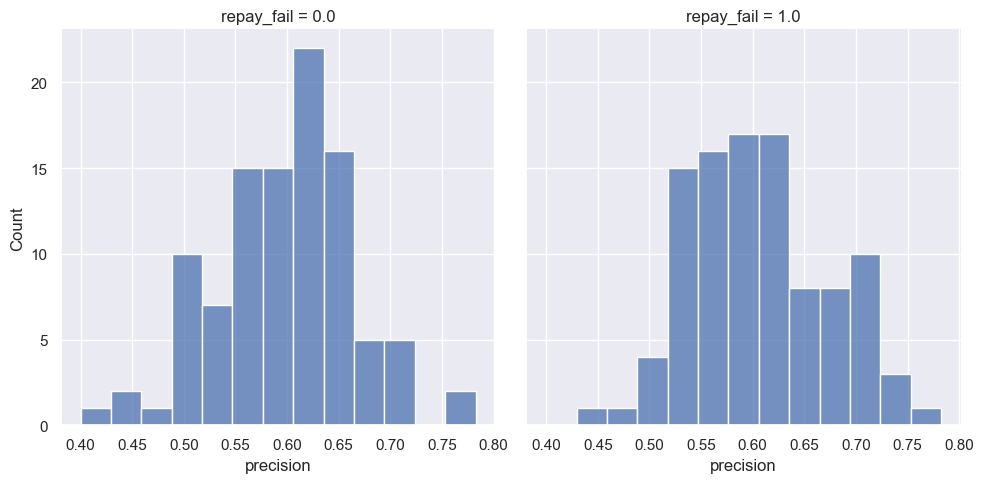

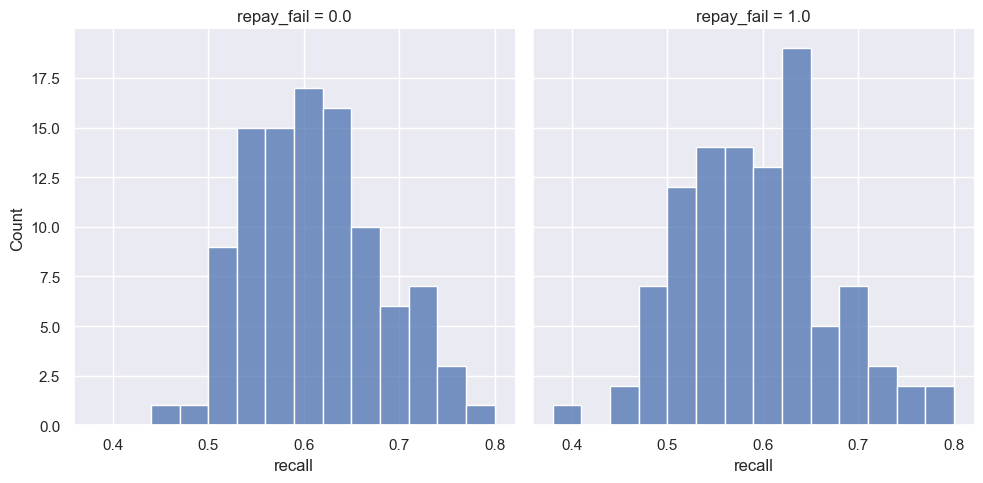

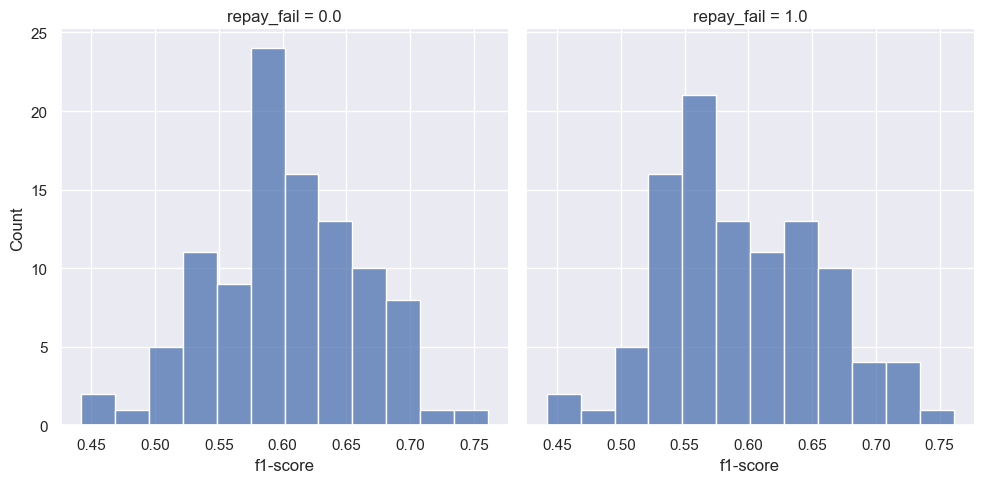

In [84]:
# Iterate through the DataFrame's columns
for col in results_df.columns:
    
    # Do not iterate through the 'support' or 'repay_fail' columns
    if col not in ['support', 'repay_fail']:
        
        # Plot the distribution of precision, recall and F1 score with columns split by loan defult status
        g = sns.displot(x=col, kind='hist', col = 'repay_fail', data=results_df)
        
        # Show plot
        plt.show()

Then, we plot the distribution of the precision, recall and F1 scores for the different samples of 100. The model averages around a 60% score for all three regardless of the loan being defaulted or non-defaulted.

In [85]:
# Split data
X_futile = u_data_test.drop(columns='repay_fail')
y_futile = u_data_test.repay_fail

# Reordering columns of X_futile to match the training data's feature order
X_futile = X_futile[['loan_amnt', 'term', 'int_rate', 'installment', 
                     'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 
                     'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc', 
                     'annual_inc_log', 'years_of_credit', 'home_ownership_OTHER', 
                     'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Verified',
                     'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 
                     'purpose_home_improvement', 'purpose_other', 'purpose_small_business']]

# Predict on test data
y_pred_futile = xgb_gs_new.predict(X_futile)

# Get prediction probabilities
y_probs_futile = xgb_gs_new.predict_proba(X_futile)[:,1]

# Evaluate predictions
display(pd.DataFrame(classification_report(y_futile, y_pred_futile,output_dict=True)).T)
print("XGBoost AUC: ", roc_auc_score(y_futile, y_probs_futile))

,precision,recall,f1-score,support
0,0.601826,0.613678,0.607694,14827.000000
1,0.605890,0.593957,0.599864,14826.000000
accuracy,0.603817,0.603817,0.603817,0.603817
macro avg,0.603858,0.603817,0.603779,29653.000000
weighted avg,0.603858,0.603817,0.603779,29653.000000


XGBoost AUC:  0.6488826626360442


Overall on the test set, as we noticed in the distributions, the model averages around 60% for all scores. The model is still overfit to the original training data, but now has more predictive ability for unseen data with the addition of the new dataset. 

It is evident that the XGBoost Classifier model has reached its peak performance through the introduction of an unseen dataset. Despite fine-tuning the hyperparameters and enhancing the training data, the model's performance has plateaued, showing no significant improvement. The plateau suggests that the model has grown increasingly complex, and we're now experiencing diminishing marginal returns in terms of its predictive accuracy. While we could continue to refine the parameters and further augment the training data, the expected gains would be minimal compared to the effort needed for further improvement.

## 4.12 References<a id='4.11_References'></a>

1. https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
2. https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
3. https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/